### L2X (learning to explain) for income prediction

This is an example of the L2X explainer. Different from LIME, SHAP or MACE, L2X trains a separate model for explanation. The advantage of L2X is that it generates explanations fast after the explanation model is trained. The disadvantage is that the quality of the explanations highly depend on the trained explanation model, which can be affected by multiple factors, e.g., the network structure of the explanation model, the training hyperparameters. 

For tabular data, we implement the default explanation model in `omnixai.explainers.tabular.agnostic.L2X.l2x`. One may implement other models by following the same interface (please refer to the docs for more details). If using this explainer, please cite the original work: "Learning to Explain: An Information-Theoretic Perspective on Model Interpretation, Jianbo Chen, Le Song, Martin J. Wainwright, Michael I. Jordan, https://arxiv.org/abs/1802.07814".

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import os
import sklearn
import xgboost
import numpy as np
import pandas as pd
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform

The dataset used in this example is for income prediction (https://archive.ics.uci.edu/ml/datasets/adult). We recommend using `Tabular` to represent a tabular dataset, which can be constructed from a pandas dataframe or a numpy array. To create a `Tabular` instance given a numpy array, one needs to specify the data, the feature names, the categorical feature names (if exists) and the target/label column name (if exists).

In [3]:
feature_names = [
    "Age", "Workclass", "fnlwgt", "Education",
    "Education-Num", "Marital Status", "Occupation",
    "Relationship", "Race", "Sex", "Capital Gain",
    "Capital Loss", "Hours per week", "Country", "label"
]
data = np.genfromtxt(os.path.join('../data', 'adult.data'), delimiter=', ', dtype=str)
tabular_data = Tabular(
    data,
    feature_columns=feature_names,
    categorical_columns=[feature_names[i] for i in [1, 3, 5, 6, 7, 8, 9, 13]],
    target_column='label'
)

`TabularTransform` is a special transform designed for tabular data. By default, it converts categorical features into one-hot encoding, and keeps continuous-valued features (if one wants to normalize continuous-valued features, set the parameter `cont_transform` in `TabularTransform` to `Standard` or `MinMax`). The `transform` method of `TabularTransform` will transform a `Tabular` instance into a numpy array. If the `Tabular` instance has a target/label column, the last column of the transformed numpy array will be the target/label. 

If some other transformations that are not supported in the library are necessary, one can simply convert the `Tabular` instance into a pandas dataframe by calling `Tabular.to_pd()` and try different transformations with it.

After data preprocessing, we can train a XGBoost classifier for this task (one may try other classifiers).

In [4]:
np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, labels_train, labels_test = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))

gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, labels_train)
print('Test accuracy: {}'.format(
    sklearn.metrics.accuracy_score(labels_test, gbtree.predict(test))))

Training data shape: (26048, 108)
Test data shape:     (6513, 108)
Test accuracy: 0.8668816213726394


The prediction function takes a `Tabular` instance as its inputs, and outputs the class probabilities or logits for classification tasks or the estimated values for regression tasks. In this example, we simply call `transformer.transform` to do data preprocessing followed by the prediction function of `gbtree`.

In [5]:
predict_function=lambda z: gbtree.predict_proba(transformer.transform(z))

To initialize a L2X explainer, we need to set:
  
  - `training_data`: The data used to train the explainer. ``training_data`` should be the training dataset for training the machine learning model.
  - `predict_function`: The prediction function corresponding to the model.
  - `mode`: The task type, e.g., "classification" or "regression".
  - `selection_model`: A pytorch model class for estimating P(S|X) in L2X. If `selection_model = None`, a default model `DefaultSelectionModel` will be used.
  - `prediction_model`: A pytorch model class for estimating Q(X_S) in L2X. If `prediction_model = None`, a default model `DefaultPredictionModel` will be used.

In [6]:
from omnixai.explainers.tabular.agnostic.L2X.l2x import L2XTabular

explainer = L2XTabular(
    training_data=tabular_data,
    predict_function=predict_function,
)

 |████████████████████████████████████████| 100.0% Complete, Loss 0.1953
L2X prediction model accuracy: 0.8647768803169436


L2X generates local explanations, e.g. `explainer.explain` is called given the test instances. `ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance in `test_x` to plot, e.g., `index = 0` means plotting the first instance in `test_x`.

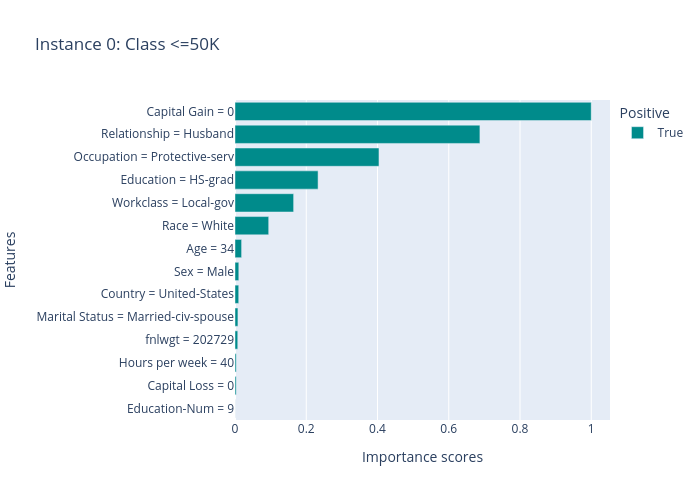

In [7]:
i = 1653
test_x = tabular_data[i:i + 5]
explanations = explainer.explain(test_x)
explanations.ipython_plot(index=0, class_names=class_names)